# Radialna odvisnost gostote zvezd k kroglastih kopicah


In [ ]:
!pip install astropy ccdproc tqdm twirl "photutils[all]"

## Piprava

Spodnja celica vkluči vse potrebne knjižnice. Pognati jo je potrebno vsakič, ko ponovno zaženemo interpreter.

In [1]:
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from ccdproc import ImageFileCollection, Combiner
import ccdproc as ccdp
from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy import units as u
from astropy.wcs.wcs import FITSFixedWarning, WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy
import twirl

# Skaliranje dark posnetkov
DARKI so narejeni z ekspozicijo 60s, M15 pa ima ekspozicijo 40s (presvetel za 60s). Za stackanje M15 sem skaliral master dark. Ta 40s master dark sem uporabil tudi pri stackanju v astap.

In [20]:
def scale_dark_frame(master_dark_path, scaled_dark_path, master_dark_exposure, light_frame_exposure):
    # Load the master dark frame
    with fits.open(master_dark_path) as hdul:
        master_dark_data = hdul[0].data  # Access image data
        header = hdul[0].header  # Access header if you need metadata

    # Scale the master dark frame
    scaling_factor = light_frame_exposure / master_dark_exposure
    scaled_dark_data = master_dark_data * scaling_factor

    #modify the header
    header["EXPTIME"] = light_frame_exposure
    header["EXPOSURE"] = light_frame_exposure

    # Save the scaled dark frame as a new FITS file
    fits.writeto(scaled_dark_path, scaled_dark_data, header, overwrite=True)
    print(f"Scaled dark frame saved to {scaled_dark_path}")


In [21]:
scale_dark_frame("master_dark_16x60s_at_-25C_2024-11-30.fit", "master_dark_scaled_40s_at_-25C_2024-11-30.fit", 60, 40)

Scaled dark frame saved to master_dark_scaled_40s_at_-25C_2024-11-30.fit


## Predpriprava in kalibracija slik

Spodnje celice pripravijo slike in jih shranijo v reduced_path. Cel proces lahko traja več kot 5 minut. Pognati je potrebno enkrat na seanso.

In [3]:
#url = 'http://astro.ago.fmf.uni-lj.si/podatki/2024/M2024-04-29.7z'
#!wget {url}
#!7za x M2024-04-29.7z
!mkdir calibrated_path reduced_path

calibrated_path = "./calibrated_path/"
reduced_path = "./reduced_path/"
dark = ImageFileCollection("./M2024-11-30/DARK/")
light = ImageFileCollection("./M2024-11-30//LIGHT/")
bias = ImageFileCollection("./M2024-11-30//BIAS/")
flat = ImageFileCollection("./M2024-11-30//FLAT/")

import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)

raw_biases = bias.files_filtered(include_path=True, imagetyp='BIAS')

combined_bias = ccdp.combine(raw_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6, unit="count"
                            )

combined_bias.meta['combined'] = True

combined_bias.write(calibrated_path + 'combined_bias.fit',overwrite=True)

for ccd, file_name in tqdm(dark.ccds(ccd_kwargs={'unit': 'count'},         # Just get the bias frames
                                          return_fname=True           # Provide the file name too.
                                         ), total=len(dark.summary), desc='Calibrating dark field images'):
    # Subtract bia
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    # Save the result
    ccd.write(calibrated_path + file_name, overwrite=True)

reduced_images = ccdp.ImageFileCollection(calibrated_path)
darks = reduced_images.summary['imagetyp'] == 'DARK'
dark_times = set(reduced_images.summary['exptime'][darks])

for exp_time in tqdm(sorted(dark_times), desc='Combining dark field images'):
    calibrated_darks = reduced_images.files_filtered(imagetyp='dark', exptime=exp_time,
                                                     include_path=True)

    combined_dark = ccdp.combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_dark.meta['combined'] = True

    dark_file_name = 'combined_dark_{:6.3f}.fit'.format(exp_time)
    combined_dark.write(calibrated_path + dark_file_name, overwrite=True)

for ccd, file_name in tqdm(flat.ccds(imagetyp='FLAT', ccd_kwargs={'unit': 'count'},           # Just get the bias frames
                                   return_fname=True           # Provide the file name too.
                                  ), total=len(flat.summary), desc='Calibrating flat field images'):
    ccd = ccdp.subtract_bias(ccd, combined_bias)
    # Subtract the dark current
    ccd = ccdp.subtract_dark(ccd, combined_dark,
                             exposure_time='exptime', exposure_unit=u.second, scale=True)

    # Save the result
    ccd.write(calibrated_path + file_name, overwrite=True)

flat_imagetyp = 'FLAT'

ifc = ccdp.ImageFileCollection(calibrated_path)
#flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters =set(['C'])


def inv_median(a):
    return 1 / np.median(a)

for filt in tqdm(flat_filters, desc='Combining flat field images'):
    to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_flat.meta['combined'] = True
    dark_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
    combined_flat.write(calibrated_path + dark_file_name, overwrite=True)

science_imagetyp = 'light'
flat_imagetyp = 'flat'
exposure = 'exposure'

ifc_reduced = ccdp.ImageFileCollection(calibrated_path)

lights = light.summary[light.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

combo_calibs = ifc_reduced.summary[ifc_reduced.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'filter', exposure]

combined_darks = {ccd.header[exposure]: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in ifc_reduced.ccds(imagetyp=flat_imagetyp, combined=True)}

# There is only one bias, so no need to set up a dictionary.
combined_bias = [ccd for ccd in ifc_reduced.ccds(imagetyp='bias', combined=True)][0]

for reduced, file_name in tqdm(light.ccds(imagetyp=science_imagetyp, return_fname=True, ccd_kwargs={'unit': 'count'},), total=len(light.summary), desc='Combining light images'):
    # Note that the first argument in the remainder of the ccdproc calls is
    # the *reduced* image, so that the calibration steps are cumulative.
    reduced = ccdp.subtract_bias(reduced, combined_bias)

    reduced = ccdp.subtract_dark(reduced, combined_darks[60.0],
                                 exposure_time='exptime', exposure_unit=u.second, scale=True)

    good_flat = combined_flats[reduced.header['filter']]
    reduced = ccdp.flat_correct(reduced, good_flat)
    ra, dec = reduced.header["RA"], reduced.header["DEC"]
    center = SkyCoord(ra, dec, unit=["deg", "deg"])
    fov = 0.864
    sky_coords = twirl.gaia_radecs(center, 1.2 * fov)[0:12]
    pixel_coords = twirl.find_peaks(reduced.data)[0:12]

    # compute the World Coordinate System
    wcs = twirl.compute_wcs(pixel_coords, sky_coords)
    reduced.header.update(wcs.to_header())
    reduced.write(reduced_path + file_name, overwrite=True)

INFO:astropy:splitting each image into 18 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 18 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


Calibrating dark field images:   0%|          | 0/16 [00:00<?, ?it/s]

Combining dark field images:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:astropy:splitting each image into 18 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 18 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


Calibrating flat field images:   0%|          | 0/7 [00:00<?, ?it/s]

Combining flat field images:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:astropy:splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 8 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


Combining light images:   0%|          | 0/62 [00:00<?, ?it/s]

# Generacija skupnih slik
Stackanje v pythonu. To je treba pognati samo enkrat. Traja okoli 30min.

In [4]:
images = ccdp.ImageFileCollection(reduced_path)

from ccdproc import wcs_project
def alignAndStack(df, targetname, objectname=None):
    target = CCDData.read(targetname).wcs
    imgs = []
    for img in tqdm(df.ccds(), total=len(df.summary), desc=objectname):
        im = wcs_project(img, target)
        imgs.append(im)

    combiner = Combiner(imgs)
    combiner.sigma_clipping(low_thresh=2, high_thresh=5, func=np.ma.median)
    return combiner.average_combine()

    

In [5]:
if len(images.files) == 0:
        print("No images found in the ImageFileCollection.")
else:
    print(f"Found {len(images.files)} images in the ImageFileCollection.")

Found 62 images in the ImageFileCollection.


In [6]:
m2S = images.filter(object="M2", filter = "C")
m15S = images.filter(object="M15", filter = "C")
m56S = images.filter(object="M56", filter = "C")
m71S = images.filter(object="M71", filter = "C")


In [7]:
m2 = alignAndStack(m2S, m2S.files[0], "M 2")
m15 = alignAndStack(m15S, m15S.files[0], "M 15")
m56 = alignAndStack(m56S, m56S.files[0], "M 56")
m71 = alignAndStack(m71S, m71S.files[0], "M 71")

M 2:   0%|          | 0/15 [00:00<?, ?it/s]

M 15:   0%|          | 0/15 [00:00<?, ?it/s]

M 56:   0%|          | 0/18 [00:00<?, ?it/s]

M 71:   0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
m2.wcs = CCDData.read(m2S.files[0]).wcs
m15.wcs = CCDData.read(m15S.files[0]).wcs
m56.wcs = CCDData.read(m56S.files[0]).wcs
m71.wcs = CCDData.read(m71S.files[0]).wcs

In [9]:
m2.to_hdu().writeto("m2.fits",overwrite=True)
m15.to_hdu().writeto("m15.fits",overwrite=True)
m56.to_hdu().writeto("m56.fits",overwrite=True)
m71.to_hdu().writeto("m71.fits",overwrite=True)

In [10]:
raw = CCDData.read("./M2024-11-30/LIGHT/M2_C_0003.fits", unit="count")
ra, dec = raw.header["RA"], raw.header["DEC"]
center = SkyCoord(ra, dec, unit=["deg", "deg"])
fov = 0.864
sky_coords = twirl.gaia_radecs(center, 1.2 * fov)[0:12]
pixel_coords = twirl.find_peaks(reduced.data)[0:12]

# compute the World Coordinate System
wcs = twirl.compute_wcs(pixel_coords, sky_coords)

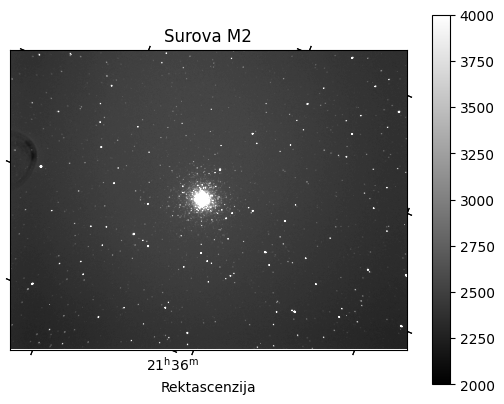

In [11]:
plt.subplot(projection=wcs)
plt.imshow(raw, vmin=2000, vmax=4000, origin='lower', cmap="gray")
plt.ylabel('Deklinacija')
plt.xlabel('Rektascenzija')
plt.title("Surova M2")
plt.colorbar()

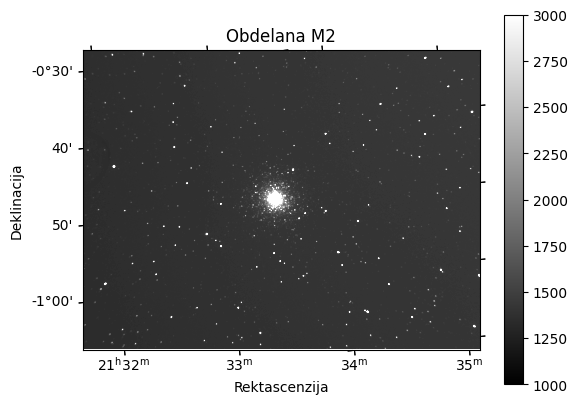

In [12]:
plt.subplot(projection=m2.wcs)
plt.imshow(m2.data, vmin=1000, vmax=3000, origin='lower', cmap="gray")
plt.ylabel('Deklinacija')
plt.xlabel('Rektascenzija')
plt.title("Obdelana M2")
plt.colorbar()

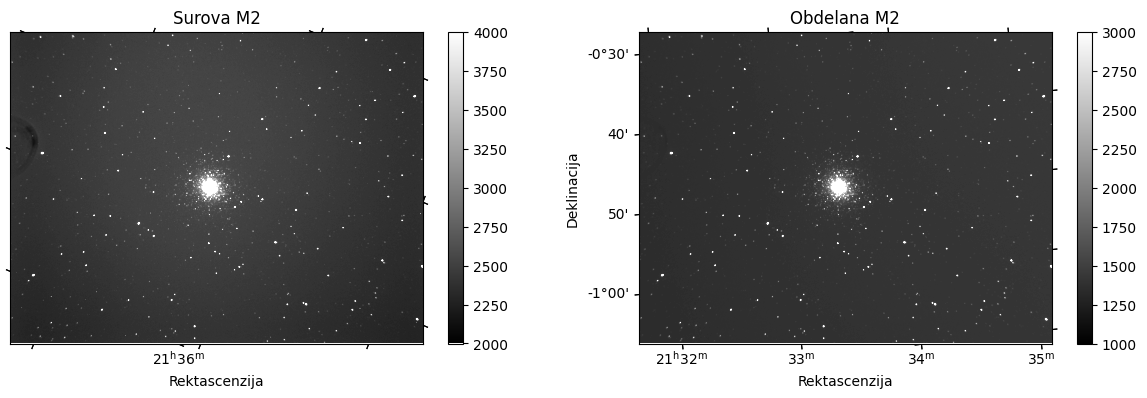

In [13]:

from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, width_ratios=[2, 2])  # Adjust width_ratios as needed

# Create axes with projections
ax1 = fig.add_subplot(gs[0], projection=wcs)
ax2 = fig.add_subplot(gs[1], projection=m2.wcs)

# Plot on the first axes
ax1.imshow(raw, vmin=2000, vmax=4000, origin='lower', cmap="gray")
ax1.set_ylabel('Deklinacija')
ax1.set_xlabel('Rektascenzija')
ax1.set_title("Surova M2")

# Create colorbar for the first plot
fig.colorbar(ax1.imshow(raw, vmin=2000, vmax=4000, origin='lower', cmap="gray"), ax=ax1, fraction=0.04)

# Plot on the second axes
ax2.imshow(m2.data, vmin=1000, vmax=3000, origin='lower', cmap="gray")
ax2.set_ylabel('Deklinacija')
ax2.set_xlabel('Rektascenzija')
ax2.set_title("Obdelana M2")

# Create colorbar for the second plot
fig.colorbar(ax2.imshow(m2.data, vmin=1000, vmax=3000, origin='lower', cmap="gray"), ax=ax2, fraction=0.04)

# Adjust layout (optional)
plt.tight_layout()

# Show the combined plot
plt.savefig("kalibracija.pdf")

# Prenos obdelanih podatkov

Če ne nameravaš spreminjati obdelave slik, poženi samo to (prišpara okoli 30 min).<br>
Slike so stackane na dva načina (da lahko izbereva boljšega). Najrepj sem jih stacka v pythonu, potem pa še v astap.

In [2]:
#podatki stackani in platesolvani v pythonu
m2 = CCDData.read("python_stacked/m2.fits")
m15 = CCDData.read("python_stacked/m15.fits")
m56 = CCDData.read("python_stacked/m56.fits")
m71 = CCDData.read("python_stacked/m71.fits")

In [18]:
#podatki stackani in platesolvani v astap
m2 = CCDData.read("astap_stacked\m2_astap_solved.fits", unit=u.adu)
m15 = CCDData.read("astap_stacked\m15_astap_solved.fits", unit=u.adu)
m56 = CCDData.read("astap_stacked\m56_astap_solved.fits", unit=u.adu)
m71 = CCDData.read("astap_stacked\m71_astap_solved.fits", unit=u.adu)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9512\2315718842.py:2: SyntaxWarning: invalid escape sequence '\m'
  m2 = CCDData.read("astap_stacked\m2_astap_solved.fits", unit=u.adu)
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9512\2315718842.py:3: SyntaxWarning: invalid escape sequence '\m'
  m15 = CCDData.read("astap_stacked\m15_astap_solved.fits", unit=u.adu)
C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_9512\2315718842.py:4: SyntaxWarning: invalid escape sequence '\m'
  m56 = CCDData.read("astap_stacked\m56_astap_solved.fits", unit=u.adu)
C:\Users\Uporabnik\AppData\Local\Temp\ipyker

## Analiza podatkov

Spodnje celice dejansko analizirajo podatke.

In [25]:
import numpy as np
import numpy.ma as ma
import scipy
from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os

from astropy.io import fits
from astropy.modeling.models import Gaussian2D
from astropy.visualization import simple_norm
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs import WCS
from astropy.modeling import models
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy.table import Table

from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.datasets import make_4gaussians_image
from photutils.centroids import (centroid_1dg, centroid_2dg, centroid_com, centroid_quadratic)
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model
from photutils.datasets import make_noise_image

from PIL import Image
from skimage.draw import line
from skimage.measure import profile_line

import cv2

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad

# Računanje gostote zvezd

In [27]:
class Cluster: #razred za analizo kopice
    def __init__(self, name, data, wcs):
        self.name = name
        self.data = data
        self.wcs = wcs
        self.centre = None

    def gaia_query(self, plot=False, search_radius=0.5):
        #center, lastno gibanje, paralaksa iz simbad
        Simbad.add_votable_fields('pmra', 'pmdec', 'plx')
        simbad_data = Simbad.query_object(self.name)
        pmra = simbad_data['PMRA'][0]  # Proper motion in RA (mas/year)
        pmdec = simbad_data['PMDEC'][0]  # Proper motion in DEC (mas/year)
        plx = simbad_data['PLX_VALUE'][0]  # Parallax (mas)
        ra=simbad_data['RA'][0]
        dec=simbad_data['DEC'][0]
        coords = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))
        ra_center=coords.ra.deg
        dec_center=coords.dec.deg
        plx_range = 0.01*plx #paralaksa se lahko razlikuje za 1% (to se da prilagoditi)
        pm_range = 0.01*np.sqrt(pmra**2 + pmdec**2)

        query = f"""
        SELECT ra, dec, pmra, pmdec, parallax, parallax_over_error
        FROM gaiadr3.gaia_source
        WHERE 1 = CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {ra_center}, {dec_center}, {search_radius}))
        AND parallax > 0
        AND parallax NOT BETWEEN {plx - plx_range} AND {plx + plx_range}
        """

        #tole je še query z dodatnimi pogoji za lastno gibanje. Nisem ga uporabi, ker je za nekatere kopice izključil preveč zvezd. 
        '''
        query = f"""
        SELECT ra, dec, pmra, pmdec, parallax, parallax_over_error
        FROM gaiadr3.gaia_source
        WHERE 1 = CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {ra_center}, {dec_center}, {search_radius}))
        AND parallax > 0
        AND parallax_over_error > 2
        AND parallax NOT BETWEEN {plx - plx_range} AND {plx + plx_range}
        AND NOT 1 = CONTAINS(POINT('ICRS', pmra, pmdec), CIRCLE('ICRS', {pmra}, {pmdec}, {pm_range}))
        """

        job = Gaia.launch_job_async(query) #poizvedba v gaia bazo, ki vrne zvezde v območju kopice, ki se po lastnem gibanju in paralaksi ne ujemajo s kopico
        gaia_data = job.get_results()
        '''

        job = Gaia.launch_job_async(query) #poizvedba v gaia bazo, ki vrne zvezde v območju kopice, ki se po lastnem gibanju in paralaksi ne ujemajo s kopico
        gaia_data = job.get_results()

        if plot:
            cluster_ra = gaia_data['ra']
            cluster_dec = gaia_data['dec']

            plt.figure(figsize=(10, 8))
            plt.subplot(projection=self.wcs)
            plt.imshow(self.data, cmap='gray', vmin = 1000, vmax=3000)
            plt.xlabel('RA')
            plt.ylabel('Dec')

            plt.scatter(cluster_ra, cluster_dec, transform=plt.gca().get_transform('world'), s=10, edgecolor='red', facecolor='none', label='Non Cluster Members')
            plt.legend()
            plt.show()

        return gaia_data, simbad_data

    def Data_analysis(self, initial_data):
        masked_data = ma.masked_invalid(initial_data)
        median = ma.median(masked_data)
        corrected_data = initial_data - median
        return corrected_data
    
    def Gaussian(self, x, height, x_center, std, offset):
        return(height * (np.exp(-((x-x_center)**2 / (2*std**2)))) + offset)

    def Gaussian_fit(self, x_axis, y_axis, initial_vals):
        fit_param, statis = curve_fit(self.Gaussian, x_axis, y_axis, initial_vals)
        model = self.Gaussian(x_axis, *fit_param) 
        return model, fit_param
    
    def king_model(self, r, rho0, rc, rt):#kingov model: rc je radij jedra, rt je plimski radij
        return rho0 * (1 / np.sqrt(1 + (r / rc)**2) - 1 / (np.sqrt(1 + (rt / rc)**2)**2))**2
    
    def Surface_density(self, annulii):
        area = np.pi*(annulii[1][1:]**2 - annulii[1][:-1]**2)
        surf_dens = annulii[0]/area
        annulli_cent = np.convolve(annulii[1],np.array([0.5, 0.5]), mode= 'valid')
        errors = np.sqrt(annulii[0])/area
        return surf_dens, errors , annulli_cent

    def find_stars(self, plot=False, gaia=True):
        wcs=self.wcs
        data = self.data
        mean, median, std = sigma_clipped_stats(data, sigma=3)
        
        data[np.isnan(self.Data_analysis(data))] = 0 #nan spremeni v 0
        daofind = DAOStarFinder(threshold = 5*std, fwhm = 3) #iskanje zvezd v kopici, ki so svetlejše od 4*std in imajo fwhm=3

        sources = daofind(data) #prepoznane zvezde v kopici, koordinate v px
        x_coords = sources['xcentroid']
        y_coords = sources['ycentroid']
        fits_coords = SkyCoord.from_pixel(x_coords, y_coords, wcs)

        gaia_data = self.gaia_query()[0] #zvezde v območju kopice iz gaia baze
        gaia_ra = gaia_data['ra']
        gaia_dec = gaia_data['dec']
        gaia_non_cluster_coords = SkyCoord(ra=gaia_ra, dec=gaia_dec) #zvezde ki po gaia bazi niso v kopici

        if gaia:
            # Perform cross-matching
            idx, d2d, d3d = fits_coords.match_to_catalog_sky(gaia_non_cluster_coords)
            match_threshold = 2.0 * u.arcsec # dovoljena napaka pri ujemanju z zvezdami iz gaia baze, ki niso v kopici
            matches = d2d < match_threshold 
            cluster_member_mask = ~matches # ~ is the logical NOT operator, return the opposite of the matches
            sources= sources[cluster_member_mask]
        
        x_coords = sources['xcentroid']
        y_coords = sources['ycentroid']

        if plot:
            plt.figure(figsize=(10, 8))
            plt.subplot(projection=self.wcs)

            plt.imshow(data, cmap='gray', origin='lower', vmin=mean, vmax=mean+3*std)
            plt.colorbar(label='Pixel Value')
        
            #plt.scatter(filtered_x_coords, filtered_y_coords, s=10, edgecolor='yellow', facecolor='none', label='Cluster members', alpha=1)
            plt.scatter(x_coords, y_coords, marker=".", color="yellow", label='Cluster members', alpha=1)
            print("Število zvezd v kopici: ", len(sources))

            plt.legend()
            plt.title("Identifikacija zvezd v kopici "+self.name)
            plt.xlabel("ra")
            plt.ylabel("dec")
            plt.show()

        return sources
        

    
    def gostota(self, radius=12, gaia=True): #radius to seasrch in arcmin
        bin_N = 200
        wcs=self.wcs
        pixel_scale = np.sqrt(wcs.pixel_scale_matrix[0, 0]**2 + wcs.pixel_scale_matrix[1, 0]**2) * 3600 # Convert rc and rt from pixels to arcseconds using WCS

        sources=self.find_stars(gaia=gaia)

        # Convert pixel coordinates to world coordinates (RA, Dec)
        ra_coords, dec_coords = wcs.all_pix2world(sources['xcentroid'], sources['ycentroid'], 1)

        # Fit Gaussian to determine the center of sources
        x_centroid = sources['xcentroid']
        y_centroid = sources['ycentroid']

        x_star = np.histogram(sources['xcentroid'], bins = bin_N)
        y_star = np.histogram(sources['ycentroid'], bins = bin_N)

        # Fit Gaussian to x_star and y_star histograms
        x_initial_vals = [np.max(x_star[0]), np.mean(x_star[1]), np.std(x_star[1]), np.min(x_star[0])]
        y_initial_vals = [np.max(y_star[0]), np.mean(y_star[1]), np.std(y_star[1]), np.min(y_star[0])]

        x_model, x_fit_param = self.Gaussian_fit(x_star[1][:-1], x_star[0], x_initial_vals)
        y_model, y_fit_param = self.Gaussian_fit(y_star[1][:-1], y_star[0], y_initial_vals)

        center_x = x_fit_param[1]
        center_y = y_fit_param[1]

        # Plot the Gaussian fits
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.hist(x_star[1][:-1], bins=bin_N, weights=x_star[0], color='blue', alpha=0.7, label='Data')
        ax1.plot(x_star[1][:-1], x_model, color='red', label='Gaussian Fit')
        ax1.set_xlabel('X Pixel')
        ax1.set_ylabel('Number of Stars')
        ax1.set_title('Gaussian Fit to X Star Distribution')
        ax1.legend()

        ax2.hist(y_star[1][:-1], bins=bin_N, weights=y_star[0], color='green', alpha=0.7, label='Data')
        ax2.plot(y_star[1][:-1], y_model, color='red', label='Gaussian Fit')
        ax2.set_xlabel('Y Pixel')
        ax2.set_ylabel('Number of Stars')
        ax2.set_title('Gaussian Fit to Y Star Distribution')
        ax2.legend()

        plt.tight_layout()
        plt.show()


        r_stars = np.sqrt((center_x-sources['xcentroid'])**2 + (center_y-sources['ycentroid'])**2)
        r_stars_arc = r_stars * pixel_scale
        r_stars_arc = r_stars_arc[r_stars_arc <= radius*60*pixel_scale]

        annulii = np.histogram(r_stars_arc, bins=bin_N)
        surface_density, numb_error, r_cent_annulii = self.Surface_density(annulii)

        # Fit King's model to the observed density
        popt, pcov = curve_fit(self.king_model, r_cent_annulii, surface_density, p0=[3,8,1])

        # Extract fitted parameters
        rho0, rc_arc, rt_arc = abs(popt)

        # Generate King's model profile for comparison
        r_fit_arc = np.linspace(0, np.max(r_stars_arc), 1000)
        density_fit = self.king_model(r_fit_arc, rho0, rc_arc, rt_arc)

        # Plot results
        plt.figure(figsize=(8, 6))
        plt.scatter(r_cent_annulii, surface_density, label='Observed dN/dS', color='blue')
        plt.plot(r_fit_arc, density_fit, label=f"King's Model\nrho0={rho0:.2f}, rc={rc_arc:.2f}, rt={rt_arc:.2f}", color='red')
        plt.xlabel('Radius (arcsec)')
        plt.ylabel('Surface Density (dN/dS)')
        plt.title('Star Density Profile vs King’s Model')
        plt.legend()
        plt.grid()
        plt.show()

        print(f"Core radius (rc) [arcsec]: {rc_arc:.2f}")
        print(f"Tidal radius (rt) [arcsec]: {rt_arc:.2f}")

        # Calculate the number of stars within the tidal radius (rt)
        stars_within_rt = np.sum(r_stars_arc <= rt_arc)
        print(f"Number of stars within the tidal radius (rt): {stars_within_rt}")
        stars_within_rc = np.sum(r_stars_arc <= rc_arc)
        print(f"Number of stars within the core radius (rc): {stars_within_rc}")

INFO: Query finished. [astroquery.utils.tap.core]


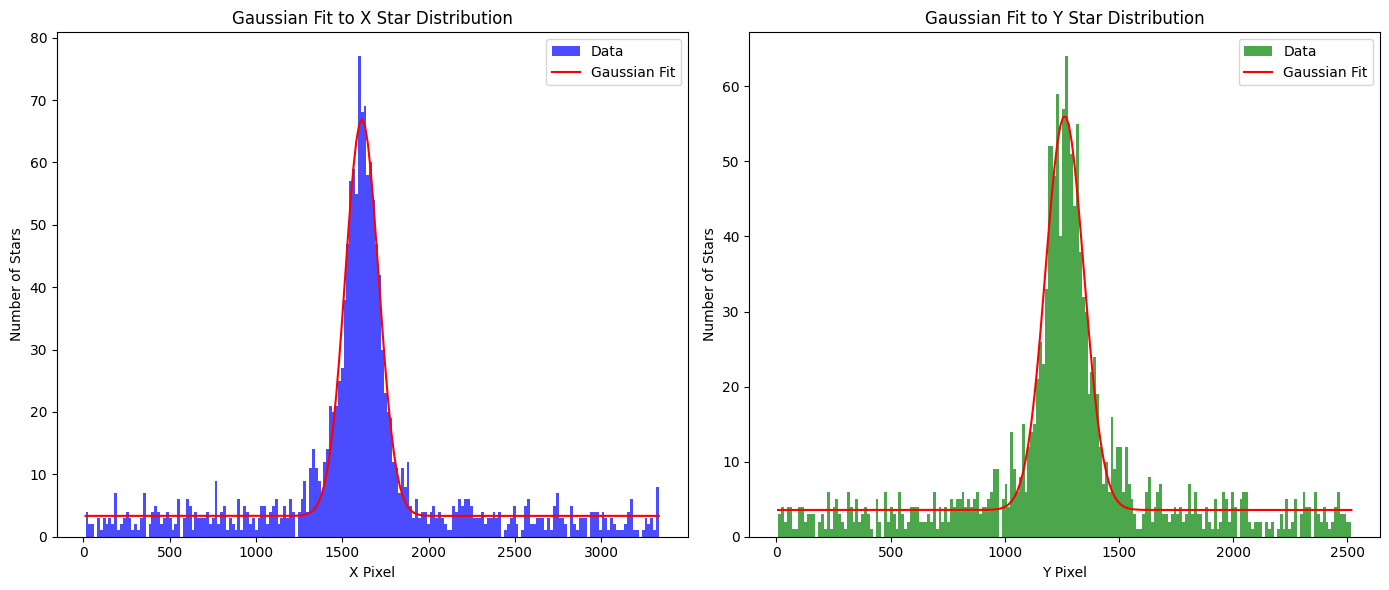

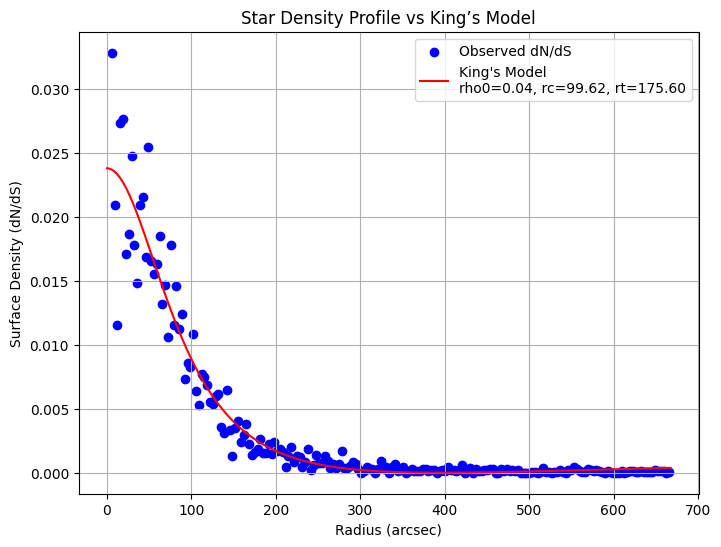

Core radius (rc) [arcsec]: 99.62
Tidal radius (rt) [arcsec]: 175.60
Number of stars within the tidal radius (rt): 750
Number of stars within the core radius (rc): 462


'\ncl.gostota() dela uredu za M2 in M15 (vsaj nekako smiselni podatki), za M56 in M71 pa ne vrne smiselnih podatkov, verjetno ker sta prešibki?\n'

In [28]:
'''
koordinate kopic:
M2: 21h33m27.02s -00d49m23.7s
M15: 21h29m58.33s +12d10m01.2s
M56: 19h16m35.57s +30d11m00.5s
M71: 19h53m46.49s +18d46m45.1s
'''

'''
cl = Cluster("M2", m2.data, m2.wcs)

cl = Cluster("M15", m15.data, m15.wcs)

cl = Cluster("M56", m56.data, m56.wcs)

cl = Cluster("M71", m71.data, m71.wcs)
'''

cl = Cluster("M2", m2.data, m2.wcs)
cl.gostota(gaia=False) #gaia=True izloči zvezde, ki po Gaia bazi niso v kopici, gaia=False upošteva vse zvezde, ki so bile prepoznane v kopici s pomočjo DAOStarFinder
#cl.find_stars(plot=True, gaia=False)
#cl.gaia_query()

'''
cl.gostota() dela uredu za M2 in M15 (vsaj nekako smiselni podatki), za M56 in M71 pa ne vrne smiselnih podatkov, verjetno ker sta prešibki?
'''


